# 3.2 Visualize Dataset

##### Description

Visualizations of the dataset.

##### Notebook Steps

1. Connect Spark
1. Input data
1. Basic data review
1. Visualize relationships

## 1. Connect Spark

In [1]:
%load_ext sparkmagic.magics

In [2]:
%manage_spark

MagicsControllerWidget(children=(Tab(children=(ManageSessionWidget(children=(HTML(value='<br/>'), HTML(value='…

## 2. Input Data

In [11]:
%%spark
df = spark.read.csv("s3://jolfr-capstone3/clean/mem-features.csv", header=True, inferSchema=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KeyboardInterrupt: 

## 3. Basic Data Review

##### Dataset Shape

In [4]:
%%spark
print((corr.count(), len(corr.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(25902421, 247)

##### Dataset Schema

In [5]:
%%spark
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- msno: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- SUM(transactions-payment_plan_days): double (nullable = true)
 |-- SUM(transactions-plan_list_price): double (nullable = true)
 |-- SUM(transactions-actual_amount_paid): double (nullable = true)
 |-- SUM(transactions-price_difference): double (nullable = true)
 |-- SUM(transactions-planned_daily_price): double (nullable = true)
 |-- SUM(transactions-daily_price): double (nullable = true)
 |-- TIME_SINCE_LAST(transactions-transaction_date): double (nullable = true)
 |-- AVG_TIME_BETWEEN(transactions-transaction_date): double (nullable = true)
 |-- ALL(transactions-is_auto_renew): boolean (nullable = true)
 |-- ALL(transactions-is_cancel): boolean (nullable = true)
 |-- MODE(transactions-payment_method_id): double (nullable = true)
 |-- NUM_UNIQUE(transactions-payment_method_id): double (nullable = true)
 |-- MIN(transactions-payment_plan_days): double (nullable = true)
 |-- MIN(transactions-plan_list_pr

## 4. Data Visualization

##### Y Variable Value Counts
The label column is the y variable in this predictive model. The value counts of the binary label are below.

In [6]:
%%spark
import pandas as pd
label_counts = df.groupBy('label').count().orderBy('count')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

This command moves the label counts dataframe from the spark cluster to the local machine. This is done so the data can be plotted.

In [7]:
%%spark --output label_counts
label_counts

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[label: boolean, count: bigint]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Churn Distribution')

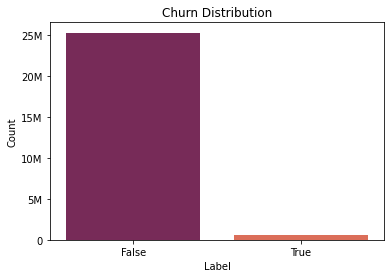

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label_counts = pd.DataFrame(label_counts).rename(columns={0:"label", 1:"count"})

sns.barplot(x="label", y="count", data=label_counts, palette="rocket")
plt.xlabel("Label")
plt.ylabel("Count")
plt.yticks([0, 5000000, 10000000, 15000000, 20000000, 25000000], ['0', '5M', '10M', '15M', '20M', '25M'])
plt.title("Churn Distribution")

##### Correlation Matrix

In [ ]:
%%spark

from pyspark.sql.functions import col
from pyspark.sql.types import BooleanType, DoubleType
import pyspark.sql.functions as f
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

dfl = df

bool_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, BooleanType)]

for column in bool_cols:
    dfl = df.withColumn(column, col(column).cast(DoubleType()))
    
dfl = dfl.withColumn("label", col("label").cast(DoubleType()))

cols = [f.name for f in dfl.schema.fields if isinstance(f.dataType, DoubleType)]

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols, outputCol=vector_col, handleInvalid="keep")
df_vector = assembler.transform(dfl).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

# get column and row mappings
mapper = {}
index = 0
for col in cols:
    mapper[index] = col
    index += 1

# reshape and add metadata    
corr = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(len(cols),len(cols))
corr = pd.DataFrame(corr).rename(mapper, axis=1)
corr_df = spark.createDataFrame(corr)

In [ ]:
%%spark
corr_df.head()

In [9]:
%%spark
# write correlation dataframe to file
corr_df.write.format("com.databricks.spark.csv").option("header", "true").mode('overwrite').save('s3://jolfr-capstone3/metadata/correlation.csv')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…